Imports

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import Flowers102, OxfordIIITPet
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

from accelerate import Accelerator
from accelerate import notebook_launcher
from tqdm.auto import tqdm

from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler
from dataclasses import dataclass

import os

from diffusers import DDPMPipeline

import pytorch_lightning as pl

import seaborn as sns

from collections import Counter

from PIL import Image

import math
import matplotlib.pyplot as plt



For reproducible results, we will be using a seed.

In [21]:
torch.manual_seed(42)

### Data acquisition and analysis
We will be using the Flowers102 and OxfordIIITPet dataset, which can be found in the torchvision library. The datasets will be downloaded from code if needed.

In [22]:
flowers_dataset = Flowers102(root="./data", split="train", transform=None, download=True)
pets_dataset = OxfordIIITPet(root="./data", split="trainval", transform=None, download=True)
print(flowers_dataset)
print(pets_dataset)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./data
    split=train
Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./data


Let's see the class distribution and the resolution of the pictures in both datasets.


In [23]:
def plot_class_size_distribution(dataset, dataset_name):
    
    classes = [label for _, label in dataset]
    class_counts = Counter(classes)
    class_sizes = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    sns.histplot(class_sizes, bins=30, kde=False) 
    plt.title(f"Class Size Distribution in {dataset_name} Dataset")
    plt.xlabel("Number of Samples per Class")
    plt.ylabel("Number of Classes")
    plt.show()

Flowers Dataset Class Distribution


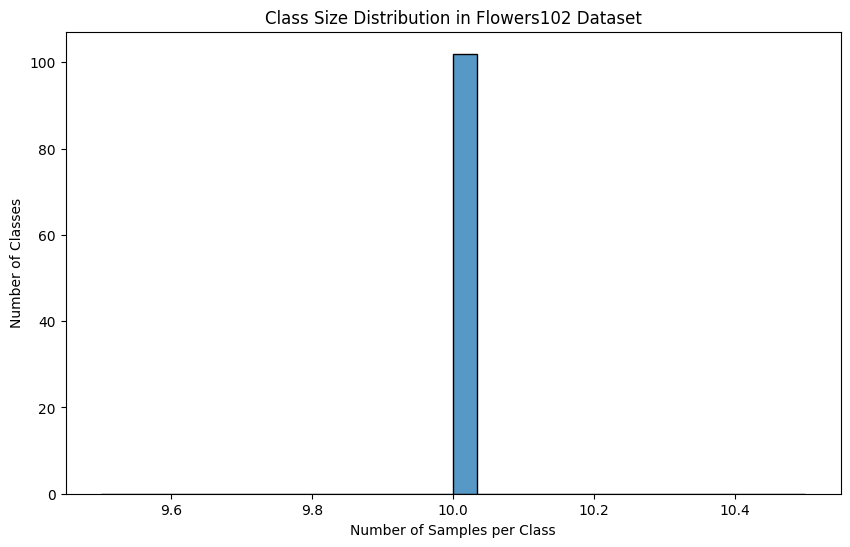


Pets Dataset Class Distribution


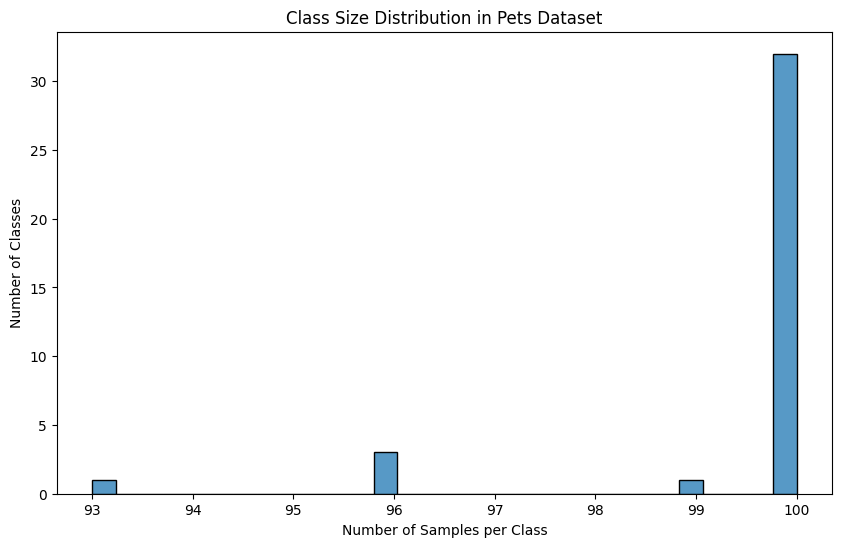

In [24]:
print("Flowers Dataset Class Distribution")
plot_class_size_distribution(flowers_dataset, "Flowers102")

print("\nPets Dataset Class Distribution")
plot_class_size_distribution(pets_dataset, "Pets")

In some classes there are a bit fewer samples than 100 so we are using cleansing on them.

In [25]:
classes = [label for _, label in pets_dataset]
class_counts = Counter(classes)

removable_classes = []
for index, count in class_counts.items():
    if(count < 100):
        removable_classes.append(index)

filtered_indices = [
    idx for idx in range(len(pets_dataset))
    if pets_dataset[idx][1] not in removable_classes
]

filtered_pets_dataset = Subset(pets_dataset, filtered_indices)


FILTERED Pets Dataset Class Distribution


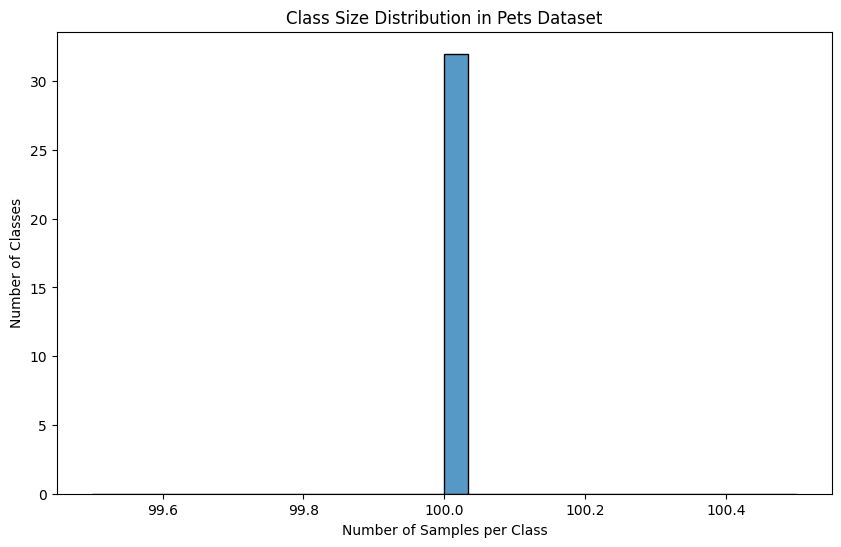

In [26]:
print("\nFILTERED Pets Dataset Class Distribution")
plot_class_size_distribution(filtered_pets_dataset, "Pets")

Now there are classes with only 100 samples in the cleaned pets dataset, so we set it as the default.

In [27]:
pets_dataset = filtered_pets_dataset

Based on the previous two diagrams, the flowers102 dataset has no discrepancies in terms of class distribution, and in the pets dataset we only have small discrepancies, which won't be a problem.

In [28]:
def categorize_resolution(width, height):
    if width < 256 and  height < 256:
        return 'Low (<256)'
    elif 256 <= width < 512 and 256 <= height < 512:
        return 'Medium (256-512)'
    elif 512 <= width < 1024 and 512 <= height < 1024:
        return 'High (512-1024)'
    else:
      return 'Very High (>=1024)'


def plot_image_size_distribution(dataset, dataset_name):
    resolution_counts = {
        'Low (<256)': 0,
        'Medium (256-512)': 0,
        'High (512-1024)': 0,
        'Very High (>=1024)': 0
    }
    for img, _ in dataset:
        if isinstance(img, str):
            img = Image.open(img)
        category = categorize_resolution(img.size[0], img.size[1])
        resolution_counts[category] += 1

    categories = list(resolution_counts.keys())
    counts = list(resolution_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue')
    plt.title(f'Image Size Distribution of {dataset_name} by Resolution Category')
    plt.xlabel('Resolution Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    plt.show()


Flowers102 Dataset Image Size Analysis


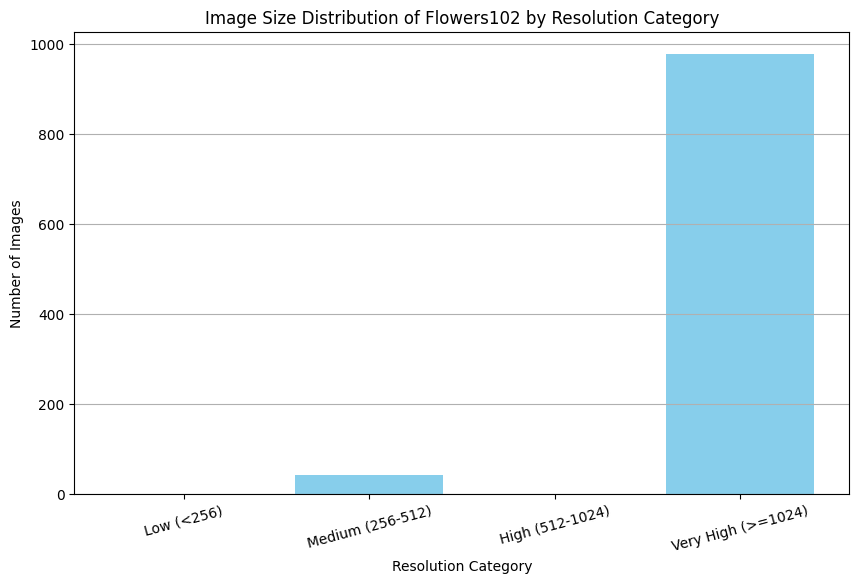


Oxford-IIIT Pet Dataset Image Size Analysis


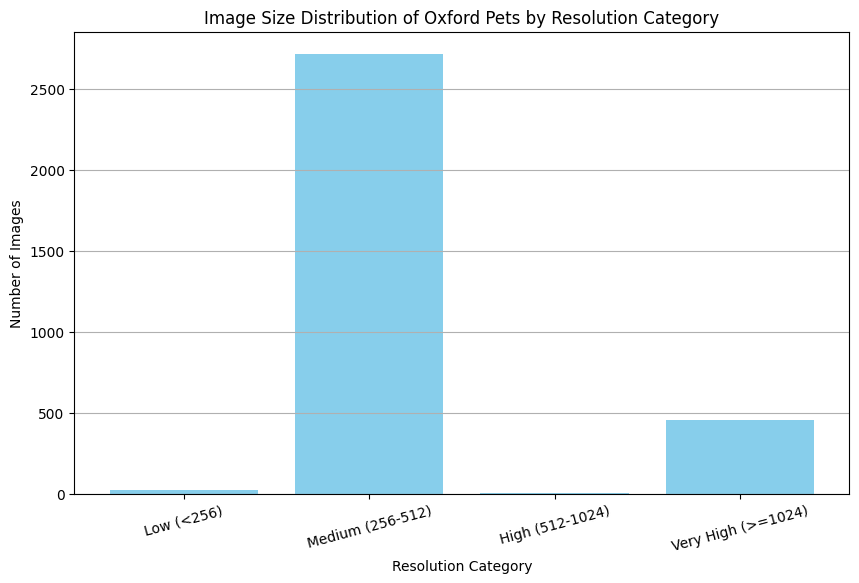

In [29]:
print("\nFlowers102 Dataset Image Size Analysis")
plot_image_size_distribution(flowers_dataset, "Flowers102")

print("\nOxford-IIIT Pet Dataset Image Size Analysis")
plot_image_size_distribution(pets_dataset, "Oxford Pets")

We will be resizing the datasets to 32x32 resolution so they will be fine like this.


### Data preparation



We will randomly split the datasets into 3 different parts, based on the following ratios:
- Train: 70%,
- Validation: 15%,
- Test: 15%,

because of our datasets don't have more than 10k samples. Also because of this, we will be loading the datasets to memory in one step rather than with a generator or streaming.

In [30]:
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    return random_split(dataset, [train_size, val_size, test_size])

In [31]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])


In [32]:
flowers_dataset = Flowers102(root="./data", split="train", transform=train_transform, download=True)
pets_dataset = OxfordIIITPet(root="./data", split="trainval", transform=train_transform, download=True)

In [33]:
flowers_train, flowers_val, flowers_test = split_dataset(flowers_dataset)
pets_train, pets_val, pets_test = split_dataset(pets_dataset)


In [34]:

flowers102_train_loader = DataLoader(flowers_train, batch_size=64, shuffle=True)
flowers102_val_loader = DataLoader(flowers_val, batch_size=64, shuffle=False)
flowers102_test_loader = DataLoader(flowers_test, batch_size=64, shuffle=False)

oxford_pets_train_loader = DataLoader(pets_train, batch_size=64, shuffle=True)
oxford_pets_val_loader = DataLoader(pets_val, batch_size=64, shuffle=False)
oxford_pets_test_loader = DataLoader(pets_test, batch_size=64, shuffle=False)

In [35]:
print(f"Flowers102 dataset: {len(flowers_train)} training, {len(flowers_val)} validation, {len(flowers_test)} test samples")
print(f"Oxford-IIIT Pets dataset: {len(pets_train)} training, {len(pets_val)} validation, {len(pets_test)} test samples")

Flowers102 dataset: 714 training, 153 validation, 153 test samples
Oxford-IIIT Pets dataset: 2576 training, 552 validation, 552 test samples



### Baseline model

We are implementing a simple VAE(Variational Autoencoder) so we can use it as a baseline model.


In [36]:

class VAE(pl.LightningModule):
    def __init__(self, latent_dim=2, learning_rate=1e-3):
        super(VAE, self).__init__()
        self.learning_rate = learning_rate
        self.latent_dim = latent_dim

        # Encoder
        self.enc = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 4, 2, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 4, 2, 1),
            torch.nn.ReLU(),
            torch.nn.Flatten()
        )
        
        output_shape = self._get_output_shape((3, 32, 32))

        self.fc_mu = nn.Linear(output_shape, latent_dim)
        self.fc_logvar = nn.Linear(output_shape, latent_dim)
        
        vmi = output_shape / 32
        vmi = int(math.sqrt(vmi))
        
        self.dec = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, output_shape),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (32, vmi, vmi)),
            torch.nn.ConvTranspose2d(32, 32, 4, 2, 1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, 4, 2, 1), 
            torch.nn.Tanh()
        )

    def _get_output_shape(self, shape):
        '''Returns the size of the output tensor from the conv layers.'''
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.enc(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc_output = self.enc(x)
        mu = self.fc_mu(enc_output)
        logvar = self.fc_logvar(enc_output)
        z = self.reparameterize(mu, logvar)
        return self.dec(z), mu, logvar

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_reconstructed, mu, logvar = self(x)
        KL = 0.5 * torch.sum(mu**2 + torch.exp(logvar) - 1 - logvar)
        reconstruction_loss = F.mse_loss(x_reconstructed, x, reduction="sum")
        loss = reconstruction_loss + KL
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_reconstructed, mu, logvar = self(x)
        KL = 0.5 * torch.sum(mu**2 + torch.exp(logvar) - 1 - logvar)
        reconstruction_loss = F.mse_loss(x_reconstructed, x, reduction="sum")
        loss = reconstruction_loss + KL
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_reconstructed, mu, logvar = self(x)
        KL = 0.5 * torch.sum(mu**2 + torch.exp(logvar) - 1 - logvar)
        reconstruction_loss = F.mse_loss(x_reconstructed, x, reduction="sum")
        loss = reconstruction_loss + KL
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [37]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu124
True


Let's train two seperate models for the two datasets so we can later compare them by predefined metrics.


In [38]:
model_flowers = VAE(latent_dim=64)
model_pets = VAE(latent_dim=64)
flower_trainer = pl.Trainer(max_epochs=20,accelerator='gpu',devices=1)
pets_trainer = pl.Trainer(max_epochs=20,accelerator='gpu',devices=1)
flower_trainer.fit(model_flowers, flowers102_train_loader)
pets_trainer.fit(model_pets,oxford_pets_train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
e:\melytan\hazi\.venv\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | enc       | Sequential | 18.0 K | train
1 | fc_mu     | Linear     | 131 K  | train
2 | fc_logvar | Linear     | 131 K  | train
3 | dec       | Sequential | 151 K  | train
-------------------------------------------------
431 K     Trainable params
0         Non-trainable params
431 K     Total params
1.725     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
e:\melytan\hazi\.venv\Lib\site-pac

Epoch 19: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 12/12 [00:02<00:00,  5.34it/s, v_num=16]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | enc       | Sequential | 18.0 K | train
1 | fc_mu     | Linear     | 131 K  | train
2 | fc_logvar | Linear     | 131 K  | train
3 | dec       | Sequential | 151 K  | train
-------------------------------------------------
431 K     Trainable params
0         Non-trainable params
431 K     Total params
1.725     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
e:\melytan\hazi\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Epoch 19: 100%|██████████| 41/41 [00:08<00:00,  5.08it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 41/41 [00:08<00:00,  5.06it/s, v_num=17]


Let's plot some of the pictures and their VAE reconstructed counterparts from both datasets.

In [39]:

def unnormalize(img):
    return (img + 1) / 2

def plot_reconstructions(model, data_loader, num_images=10):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images[:num_images] 
    
    with torch.no_grad():
        recon_images, _, _ = model(images.to(model.device))
    
    recon_images = recon_images.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
     
        axes[0, i].imshow(unnormalize(images[i]).permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(unnormalize(recon_images[i]).permute(1, 2, 0).cpu().numpy())
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()



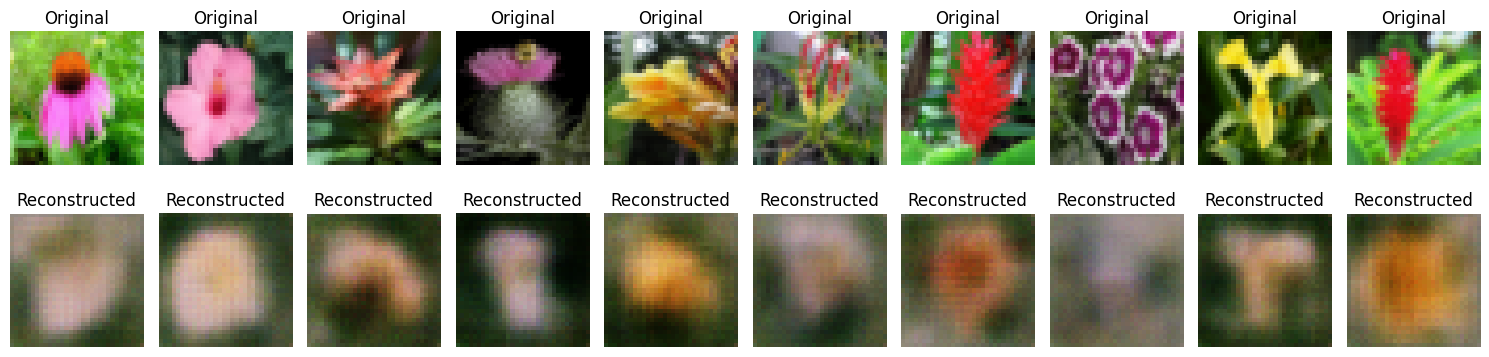

In [40]:
plot_reconstructions(model_flowers, flowers102_val_loader)

Since this dataset is smaller, the reconstructions are also lacking.

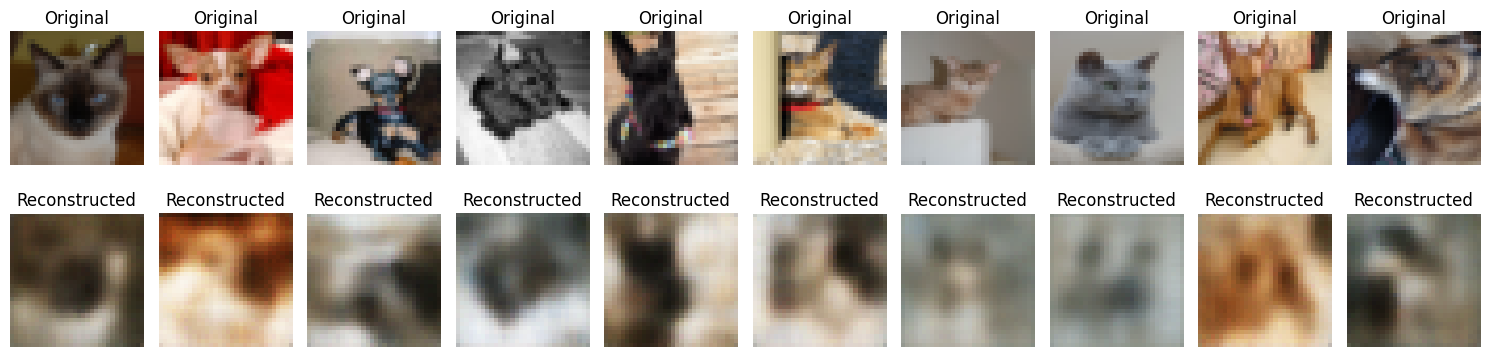

In [41]:
plot_reconstructions(model_pets, oxford_pets_val_loader)

This dataset is marginally larger, so the reconstructions are visibly cleaner, and shapes can be recognized.


### Defining Evaluation Criteria

For evaluating the quality of generated images from the diffusion models, we will use the following metrics:

1. **Fréchet Inception Distance (FID)**: Measures the similarity between generated images and real images by comparing the mean and covariance of features extracted from the Inception network. Lower values are better, indicating closer similarity to real data.

2. **Inception Score (IS)**: Measures the quality of generated images based on their diversity and how "confident" the Inception network is in classifying them into distinct categories. Higher scores indicate better diversity and quality.

We will implement and calculate these metrics after training the diffusion models.


In [42]:
def calculate_fid(real_images_loader, model):
    model = model.to("cuda")
    fid_metric = FrechetInceptionDistance().to("cuda")
    
    
    for real_images, _ in real_images_loader:
        real_images = (real_images * 255).byte() 
        fid_metric.update(real_images.to("cuda"), real=True)
    
    for real_images, _ in real_images_loader:
        real_images = real_images.to("cuda")  
        generated_images, _, _ = model(real_images) 
        generated_images = (generated_images * 255).clamp(0, 255).byte() 
        fid_metric.update(generated_images, real=False)  
    
    return fid_metric.compute()

In [43]:
def calculate_inception_score(real_images_loader, model):
    model = model.to("cuda")
    inception_score = InceptionScore().to("cuda")
   
    for real_images, _ in real_images_loader:
        generated_images, _, _ = model(real_images.to("cuda"))  
        generated_images = (generated_images * 255).clamp(0, 255).byte()
        inception_score.update(generated_images)

    score = inception_score.compute()
    return score[0].item()  

In [44]:

fid_value = calculate_fid(flowers102_val_loader, model_flowers)
print("FID:", fid_value)

inception_score_value = calculate_inception_score(flowers102_val_loader, model_flowers)
print("Inception Score:", inception_score_value)

FID: tensor(318.1361, device='cuda:0')


e:\melytan\hazi\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Inception Score: 2.35695219039917


The calculated metrics give us the clue that the baseline model isn't performing really well. However, this kind of baseline will be perfect for us.

In [45]:

fid_value = calculate_fid(oxford_pets_val_loader, model_pets)
print("FID:", fid_value)

inception_score_value = calculate_inception_score(oxford_pets_val_loader, model_pets)
print("Inception Score:", inception_score_value)


FID: tensor(305.5305, device='cuda:0')
Inception Score: 2.579660415649414


The results a bit better for this dataset, this is most likely due to that larger sample size available in this dataset compared to the other one.

## Advanced model

We will be using the huggingface uncoditional image generation, pretrained DDPM model: google/ddpm-cifar10-32

We will be training this model further 2 seperate times with the 2 datasets pets and flowers.

For this part we used sources such as: HuggingFace example DDPM training notebook: https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb#scrollTo=1f740dfe-e610-4479-ac30-cce1f9e62553, most of the train_loop is based on this notebook.

We also used ChatGPT 4o, for debugging errors concerning the preparation of datasets and their usage in training.

First lets do load the two datasets again with proper transformations

In [46]:


preprocess = transforms.Compose(
    [
        #The imported pretrained DDPM model used 32x32 pictures, so we also resize to that resolution
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

flowers_dataset = Flowers102(root="./data", split="train", transform=preprocess, download=True)
pets_dataset = OxfordIIITPet(root="./data", split="trainval", transform=preprocess, download=True)

pets_dataloader = DataLoader(pets_dataset, batch_size=16, shuffle=True)
flowers_dataloader = DataLoader(flowers_dataset, batch_size=16, shuffle=True)

### Dataset: Pets

In [47]:


# Load the pretrained model from Hugging Face
model_id = "google/ddpm-cifar10-32" 
pipeline = DDPMPipeline.from_pretrained(model_id)
model = pipeline.unet

device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline.to(device)

An error occurred while trying to fetch C:\Users\Gergely\.cache\huggingface\hub\models--google--ddpm-cifar10-32\snapshots\267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\Gergely\.cache\huggingface\hub\models--google--ddpm-cifar10-32\snapshots\267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "google/ddpm-cifar10-32",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [48]:

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [49]:


@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16 
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  
    output_dir = 'ddpm-melytanulas' 

    push_to_hub = False
    hub_private_repo = False  
    overwrite_output_dir = True 
    seed = 0

config = TrainingConfig()

In [50]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [51]:

#Pets dataset scheduler
lr_scheduler_p = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(pets_dataloader) * config.num_epochs),
)


In [52]:


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator
    accelerator = Accelerator(
        mixed_precision="fp16",
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    # Prepare everything
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, (images, _) in enumerate(train_dataloader):
            clean_images = images.to("cuda")  # Move images to GPU
            noise = torch.randn_like(images).to("cuda")  # Generate noise
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

In [53]:


args = (config, model, noise_scheduler, optimizer, pets_dataloader, lr_scheduler_p)
notebook_launcher(train_loop, args, num_processes=1)


Launching training on one GPU.


e:\melytan\hazi\.venv\Lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)

Epoch 0: 100%|██████████| 230/230 [00:46<00:00,  4.98it/s, loss=0.013, lr=4.6e-5, step=229]













































































































































































































































































































































































































































































Epoch 1: 100%|██████████|

In [54]:

output_dir_p = "./trained_model_pets"

# Save the model and noise scheduler
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline.save_pretrained(output_dir_p)

100%|██████████| 50/50 [00:01<00:00, 34.63it/s]


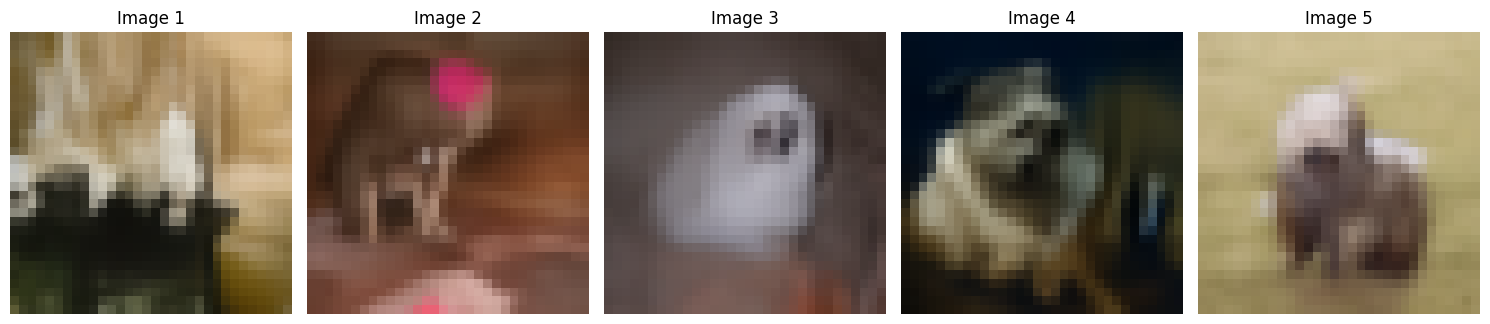

In [55]:
# Load the trained model
pipeline = DDPMPipeline.from_pretrained(output_dir_p)

device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline.to(device)

num_images = 5
num_inference_steps = 50 
generator = torch.manual_seed(42)  # Set seed for reproducibility

# Create a batch of images by repeating the process
generated_images = []
for _ in range(num_images):
    with torch.no_grad():
        # Generate one image at a time
        image = pipeline(
            num_inference_steps=num_inference_steps,
            generator=generator
        ).images[0]
        generated_images.append(image)

fig, axes = plt.subplots(1, len(generated_images), figsize=(15, 5))

for i, img in enumerate(generated_images):
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


### Dataset: flowers

In [56]:
# Load a pretrained model from Hugging Face
model_id = "google/ddpm-cifar10-32" 
pipeline = DDPMPipeline.from_pretrained(model_id)
model = pipeline.unet

device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline.to(device)

An error occurred while trying to fetch C:\Users\Gergely\.cache\huggingface\hub\models--google--ddpm-cifar10-32\snapshots\267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\Gergely\.cache\huggingface\hub\models--google--ddpm-cifar10-32\snapshots\267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 12.34it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "google/ddpm-cifar10-32",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [57]:
from dataclasses import dataclass
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16 
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  
    output_dir = 'ddpm-melytanulas' 

    push_to_hub = False
    hub_private_repo = False  
    overwrite_output_dir = True 
    seed = 0

config = TrainingConfig()

In [58]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [59]:
lr_scheduler_f = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(flowers_dataloader) * config.num_epochs),
)

In [60]:

args = (config, model, noise_scheduler, optimizer, flowers_dataloader, lr_scheduler_f)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.



Epoch 0: 100%|██████████| 64/64 [00:12<00:00,  5.11it/s, loss=0.0625, lr=1.28e-5, step=63]

































































































































Epoch 1: 100%|██████████| 64/64 [00:11<00:00,  5.45it/s, loss=0.0208, lr=2.56e-5, step=127]

Epoch 2: 100%|██████████| 64/64 [00:11<00:00,  5.44it/s, loss=0.0465, lr=3.84e-5, step=191]

































































































































Epoch 3: 100%|██████████| 64/64 [00:11<00:00,  5.49it/s, loss=0.0393, lr=5.12e-5, step=255]

Epoch 4: 100%|██████████| 64/64 [00:11<00:00,  5.52it/s, loss=0.026, lr=6.4e-5, step=319]

































































































































Epoch 5: 100%|██████████| 64/64 [00:11<00:00,  5.45it/s, loss=0.065, lr=7.68e-5, step=383]

Epoch 6: 100%|██████████| 64/64 [00:11<00:00,  5.48it/s, loss

In [61]:
output_dir_f = "./trained_model_flowers" 

# Save the model and noise scheduler
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline.save_pretrained(output_dir_f)

100%|██████████| 50/50 [00:01<00:00, 35.39it/s]


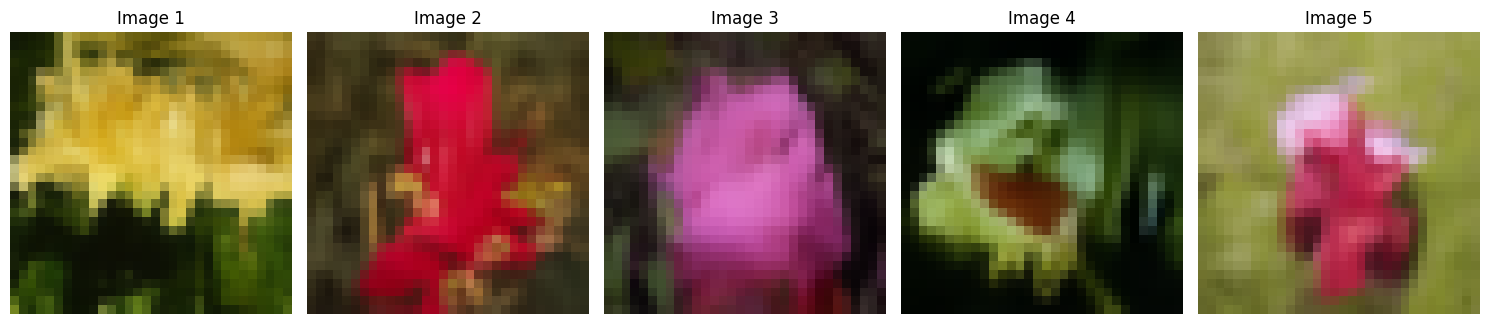

In [62]:
# Load the trained model
pipeline = DDPMPipeline.from_pretrained(output_dir_f)


device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline.to(device)


num_images = 5 
num_inference_steps = 50 
generator = torch.manual_seed(42)  # Set seed for reproducibility

# Create a batch of images by repeating the process
generated_images = []
for _ in range(num_images):
    with torch.no_grad():
        # Generate one image at a time
        image = pipeline(
            num_inference_steps=num_inference_steps,
            generator=generator
        ).images[0]
        generated_images.append(image)

fig, axes = plt.subplots(1, len(generated_images), figsize=(15, 5))

for i, img in enumerate(generated_images):
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


## Evaluating the model

We will be picking a 100 random images from each dataset, and comparing them with the model's generated images, using the previously introduced FID and inception scores. This won't be as representative as we want since don't have original images from which the model generates images.

In [73]:

from torchvision.transforms import ToTensor

def calculate_fid_ddpm(model_dir, dataloader):
    # Load the pretrained DDPM pipeline
    pipeline = DDPMPipeline.from_pretrained(model_dir)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipeline.to(device)

    # Initialize FID metric
    fid_metric = FrechetInceptionDistance().to(device)
    to_tensor = ToTensor()

    num_images = 100  # Number of images to use for FID
    num_inference_steps = 50  # Number of diffusion steps
    generator = torch.manual_seed(17)  # Set seed for reproducibility

    # Generate synthetic images and update FID metric
    for _ in range(num_images):
        with torch.no_grad():
            image = pipeline(
                num_inference_steps=num_inference_steps,
                generator=generator
            ).images[0]  # Get a single PIL image
            
            # Convert PIL image to tensor and prepare for FID
            gen_image = to_tensor(image).unsqueeze(0).to(device)  # Add batch dimension
            gen_image = (gen_image * 255).clamp(0, 255).byte()  # Scale and convert to byte
            fid_metric.update(gen_image, real=False)

    # Collect real images from the dataloader
    all_real_images = []
    for batch in dataloader:
        images, _ = batch  # Unpack images from the batch
        all_real_images.append(images)
        if len(all_real_images) * images.size(0) >= num_images:
            break

    # Concatenate real images to match num_images
    all_real_images = torch.cat(all_real_images, dim=0)[:num_images]
    real_images = (all_real_images * 255).byte()  # Scale real images to byte format

    for image in real_images:
        fid_metric.update(image.unsqueeze(0).to(device), real=True)

    # Compute and return the FID score
    return fid_metric.compute()


In [74]:
print(calculate_fid_ddpm(output_dir_p,pets_dataloader))
print(calculate_fid_ddpm(output_dir_f,flowers_dataloader))

100%|██████████| 50/50 [00:01<00:00, 34.94it/s]


tensor(309.5622, device='cuda:0')


100%|██████████| 50/50 [00:01<00:00, 33.74it/s]


tensor(256.9661, device='cuda:0')


We can see as predicted the FID scores are indeed better but not by much compared to the VAE, if we used a bigger sample size such as 1000 the score may get better, but it takes too much time to do so. 

VAE flowers FID: 318 and VAE Pets FID: 305

vs 

Flowers DDPM model FID: 309, Pets DDPM model FID: 256 

A more interesting statistic will be the Inception score which we will calculate now.

In [75]:
def calculate_IS_ddpm(model_dir):
    inception_score = InceptionScore().to("cuda")
   
    pipeline = DDPMPipeline.from_pretrained(model_dir)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipeline.to(device)

    to_tensor = ToTensor()

    num_images = 50  
    num_inference_steps = 50  
    generator = torch.manual_seed(17) 

    for _ in range(num_images):
        with torch.no_grad():
            image = pipeline(
                num_inference_steps=num_inference_steps,
                generator=generator
            ).images[0]  # Get a single PIL image
            
            # Convert PIL image to tensor and prepare for FID
            gen_image = to_tensor(image).unsqueeze(0).to(device)  # Add batch dimension
            gen_image = (gen_image * 255).clamp(0, 255).byte()  # Scale and convert to byte
            inception_score.update(gen_image)
    score = inception_score.compute()
    return score[0].item()  

In [76]:
print(calculate_IS_ddpm(output_dir_f))
print(calculate_IS_ddpm(output_dir_p))

e:\melytan\hazi\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 50/50 [00:01<00:00, 35.59it/s]


2.2606682777404785


100%|██████████| 50/50 [00:01<00:00, 33.69it/s]

2.6052818298339844


For the flowers dataset we saw a worse inception score than the baseline (2.26 DDPM vs. 2.35 VAE)

For the pets dataset we saw a slightly better inception score than the baseline (2.605 DDPM vs. 2.579 VAE)

From a human perspective, we think the ddpm model did better in both cases, the ddpm has much more colors and the objects are more visible and recognisable than it was in the VAE's case. This observation could be due to our bias towards the more complex model (ddpm), or due to the fact that these metrics can not be applied to this kind of model as good as we thought. Overall a small success is also a success, and with the huge amount of work we put in this project we are satisfied with anything thats a slightly better result. (Of course we know the DDPM IS on the flowers dataset is not as great.)